In [1]:
!pip install gtts
!pip install playsound
!pip install wordcloud

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=d13715a900f615f9e2455887c2452ad2013320eeb3ee7bad414b1cff0e899670
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import re
import pickle
import matplotlib.pyplot as plt
from keras.applications.resnet import ResNet50
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from tensorflow.keras import layers, activations, Input
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import glob
from keras.applications.inception_v3 import InceptionV3
from collections import Counter
from keras.preprocessing.text import Tokenizer
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display

import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import time
from PIL import Image

In [3]:
all_images_path = []
for image_path in os.listdir('/kaggle/input/flickr8k/Images'):
    all_images_path.append('/kaggle/input/flickr8k/Images' + '/' + image_path)

In [4]:
#all_images_path.sort()

In [5]:
# all_images_path1 = glob.glob('/kaggle/input/flickr8k/Images' + '/*.jpg', recursive = True)
# all_images_path1.sort()
# all_images_path1[:10]

In [6]:
len(all_images_path)

8091

In [7]:
image_id = []
captions = []
image_path = []
with open('/kaggle/input/flickr8k/captions.txt', 'r') as f:
    next(f)
    for line in f:
        temp = line.split(',', 1)
        image_id.append(temp[0])
        captions.append(temp[1].rstrip('\n.'))
        image_path.append('/kaggle/input/flickr8k/Images/' + temp[0])
        

In [8]:
image_path[0:5]

['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg']

In [9]:
len(image_path)

40455

In [10]:
len(captions)

40455

In [11]:
captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way ',
 'A girl going into a wooden building ',
 'A little girl climbing into a wooden playhouse ',
 'A little girl climbing the stairs to her playhouse ',
 'A little girl in a pink dress going into a wooden cabin ',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road ',
 'A black dog and a white dog with brown spots are staring at each other in the street ',
 'Two dogs of different breeds looking at each other on the road ',
 'Two dogs on pavement moving toward each other ']

In [12]:
image_path[:10]

['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg']

In [13]:
image_id_pair = pd.DataFrame({'image_path': image_path, 'captions': captions})

In [14]:
image_id_pair

,image_path,captions
0,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building
2,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse
3,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
...,...,...
40450,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man in a pink shirt climbs a rock face
40451,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man is rock climbing high in the air
40452,/kaggle/input/flickr8k/Images/997722733_0cb543...,A person in a red shirt climbing up a rock fac...
40453,/kaggle/input/flickr8k/Images/997722733_0cb543...,A rock climber in a red shirt


In [15]:
vocab = []
for caption in captions:
    caption = caption.lower()
    vocab.append(caption.split())

In [16]:
vocab = list(np.concatenate(vocab).flat)

In [17]:
len(vocab)

442473

In [18]:
vocab_count = Counter(vocab)

In [19]:
#vocab_count

In [20]:
captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way ',
 'A girl going into a wooden building ',
 'A little girl climbing into a wooden playhouse ',
 'A little girl climbing the stairs to her playhouse ',
 'A little girl in a pink dress going into a wooden cabin ',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road ',
 'A black dog and a white dog with brown spots are staring at each other in the street ',
 'Two dogs of different breeds looking at each other on the road ',
 'Two dogs on pavement moving toward each other ']

In [21]:
for i in range(len(captions)):
    caption = captions[i]
    caption = caption.lower()
    caption = re.sub(r'[^\w\s]', '', caption)
    caption = re.sub('\s+', ' ', caption)
    caption = caption.strip()
    caption = 'startseq ' + caption + ' endseq'
    captions[i] = caption
    

In [22]:
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [23]:
vocab_size = 5000 #can be tuned
tokenizer = Tokenizer(num_words = vocab_size+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ', lower = True, char_level = False, oov_token = 'UNK')

In [24]:
tokenizer.fit_on_texts(captions)

train_seq = tokenizer.texts_to_sequences(captions)

In [25]:
train_seq[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

In [26]:
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [27]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [28]:
train_seq[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

In [29]:
#tokenizer.index_word

In [30]:
train_seq_len = [len(seq) for seq in train_seq]
max_length = max(train_seq_len)

In [31]:
max_length

38

In [32]:
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq, padding= 'post', maxlen = max_length, dtype='int32', value=0)

In [33]:
padded_seq

array([[ 3,  2, 43, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 85, ...,  0,  0,  0],
       [ 3,  2, 85, ...,  0,  0,  0]], dtype=int32)

In [34]:
preprocessed_images = []
image_shape = (299,299)


In [35]:
for img_path in all_images_path[:5]:
    img_path = tf.io.read_file(img_path, name=None)
    img_path = tf.image.decode_jpeg(img_path, channels=0)
    img_path = tf.image.resize(img_path, image_shape)
    img_path = tf.keras.applications.inception_v3.preprocess_input(img_path)
    preprocessed_images.append(img_path)

In [36]:
#imshow(preprocessed_images[0])

In [37]:
len(all_images_path)

8091

In [38]:
#all_images_path

In [39]:
def load_images(image_path):
    img = tf.io.read_file(image_path, name = None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, image_shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path #tuple ban raha idhar

In [40]:
load_images("/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg")[1]

'/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'

In [41]:
sorted_img_path = sorted(set(all_images_path))
new_img = tf.data.Dataset.from_tensor_slices(sorted_img_path) #With the help of tf.data.Dataset.from_tensor_slices() method, we can get the slices of an array in the form of objects
#[x for x in new_img]
new_img = new_img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
new_img = new_img.batch(64, drop_remainder = False)

In [42]:
#a= [x for x in new_img]

In [43]:
#type(a)

In [44]:
#a[0][2]

In [45]:
path_train, path_test, caption_train, caption_test = train_test_split(image_path, padded_seq, test_size = 0.2, random_state = 42)

In [46]:
# print("Training data for images: " + str(len(path_train)))
# print("Testing data for images: " + str(len(path_test)))
# print("Training data for Captions: " + str(len(caption_train)))
# print("Testing data for Captions: " + str(len(caption_test)))

In [47]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [48]:
#image_features_extract_model.summary()

In [49]:
img_features = {}
for image, image_path in tqdm(new_img):
    batch_features = image_features_extract_model(image)
    batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_feat, path in zip(batch_features_flattened, image_path):
        feature_path = path.numpy().decode('utf-8')
        img_features[feature_path] = batch_feat.numpy()

  0%|          | 0/127 [00:00<?, ?it/s]

In [50]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.73590952e-02, 0.00000000e+00, ...,
          2.31990203e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07845321e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94018483e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85825527e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42283124e-02, 0.00000000e+00, 5.05860507e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23104107e-01, 1.33328093e-02, ...,
          2.33793616e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [51]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7359095e-02, 0.0000000e+00, ...,
         2.3199020e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0784532e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9401848e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8582553e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6567849e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0278664e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1788370e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347657e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506980e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8535922e-02, ...,
         1.2066435e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [52]:
len(img_features)

8091

In [53]:
batch_feat.shape

TensorShape([64, 2048])

In [54]:
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [55]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):    
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE) 
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    
    return data

In [56]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [57]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  
print(sample_cap_batch.shape) 

(64, 64, 2048)
(64, 38)


In [58]:
embedding_dim = 256 
units = 512

vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE  
max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [59]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [60]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [61]:
encoder=Encoder(embedding_dim)

In [62]:
from keras.utils.vis_utils import plot_model

In [63]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

In [64]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [65]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [66]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [68]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [69]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [70]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [71]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_op = encoder(img_tensor)

        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
          #pass encoder_op to decoder
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [72]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)

      #apply teacher forcing again
      for r in range(1, target.shape[1]) :
        #pass encoder_op to decoder
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)

        dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))                      


    return loss, avg_loss

In [73]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [74]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.309, & test loss is 1.082
Time taken for 1 epoch 209.0177001953125 sec

Test loss has been reduced from 100.000 to 1.082
For epoch: 2, the train loss is 0.997, & test loss is 0.952
Time taken for 1 epoch 87.3324670791626 sec

Test loss has been reduced from 1.082 to 0.952
For epoch: 3, the train loss is 0.902, & test loss is 0.874
Time taken for 1 epoch 88.08840107917786 sec

Test loss has been reduced from 0.952 to 0.874
For epoch: 4, the train loss is 0.836, & test loss is 0.816
Time taken for 1 epoch 82.93543720245361 sec

Test loss has been reduced from 0.874 to 0.816
For epoch: 5, the train loss is 0.784, & test loss is 0.768
Time taken for 1 epoch 86.89027523994446 sec

Test loss has been reduced from 0.816 to 0.768
For epoch: 6, the train loss is 0.738, & test loss is 0.724
Time taken for 1 epoch 88.746985912323 sec

Test loss has been reduced from 0.768 to 0.724
For epoch: 7, the train loss is 0.696, & test loss is 0.683
Time taken for 1 epoch 

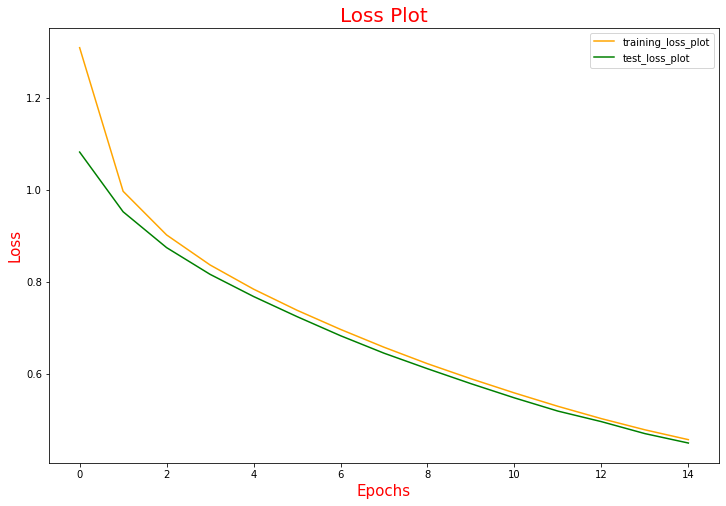

In [75]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()


In [76]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endseq':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [77]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (10, 10))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [78]:
from nltk.translate.bleu_score import sentence_bleu

In [79]:
def filt_text(text):
    filt=['startseq','<unk>','endseq'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [80]:
image_test = path_test.copy()

In [81]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]


    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BELU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)

    # we will make use of Google Text to Speech API (online), which will convert the caption to audio
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image
    


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 9.308300767049977e-153
Real Caption: a boy poses for the camera at a party
Prediction Caption: a little girl is standing in a bin


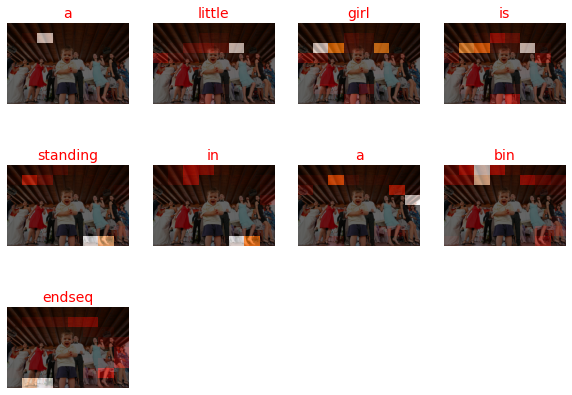

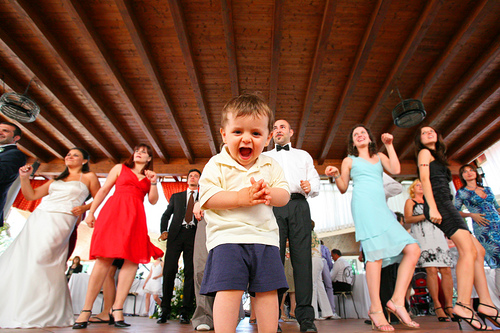

In [84]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.5, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

BELU score: 4.717068855239749e-153
Real Caption: the young child prepares to go down the slide
Prediction Caption: a young boy in a yellow tunnel on a playground


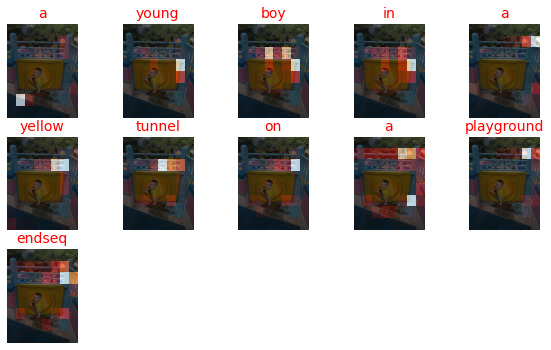

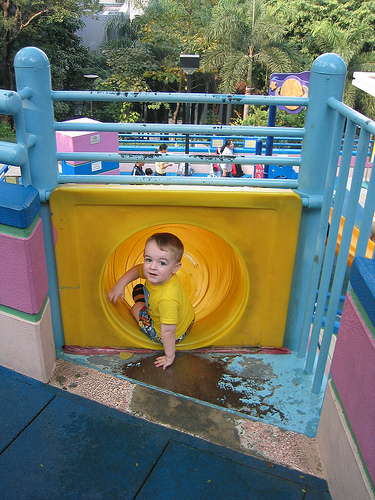

In [85]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if __name__ == "__main__":


BELU score: 39.62556917639567
Real Caption: a young child wearing a mask at UNK
Prediction Caption: a child wearing a paper mask and a paper mask on his face


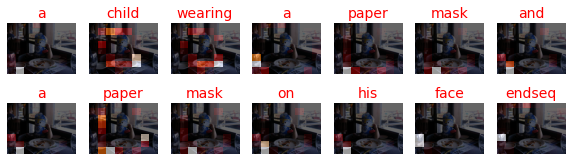

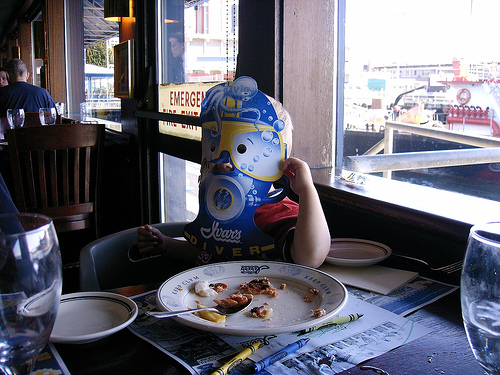

In [86]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BELU score: 52.16948600244291
Real Caption: a man walking 3 dalmatians along a sunny street
Prediction Caption: a man walking 3 bikes on the concrete buildings


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if __name__ == "__main__":


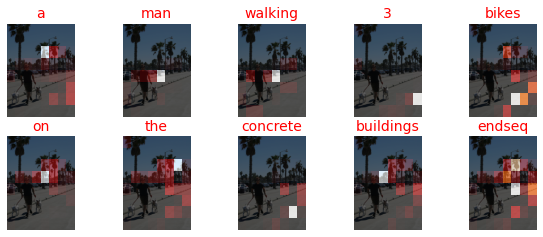

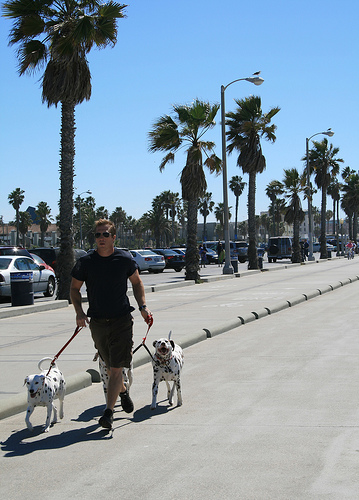

In [87]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if __name__ == "__main__":


BELU score: 37.4174731290346
Real Caption: the large white bird s reflection shows in the water
Prediction Caption: white bird is flying through the water


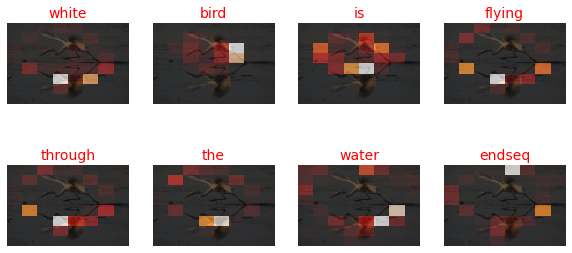

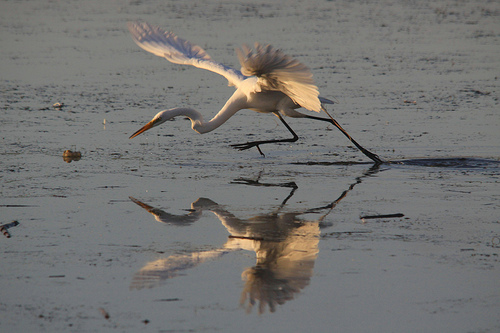

In [88]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BELU score: 40.11027420289729
Real Caption: a wet white dog is splashing in the water with a stick in its mouth
Prediction Caption: a wet white dog is in the water


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if __name__ == "__main__":


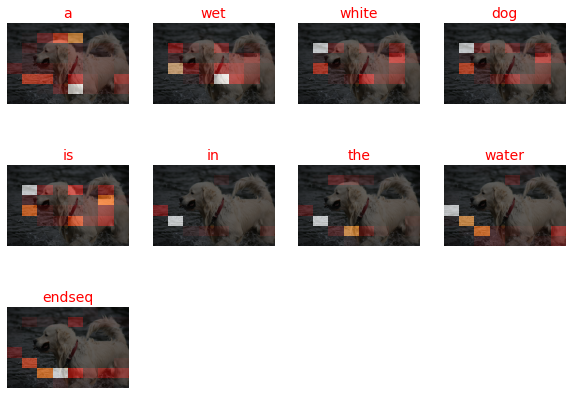

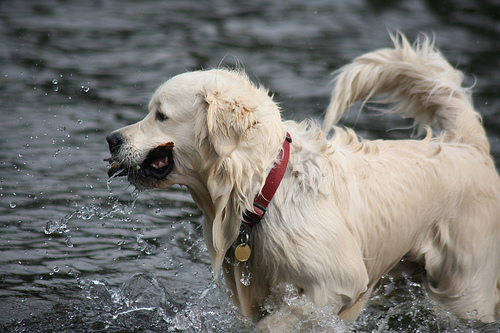

In [89]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if __name__ == "__main__":


BELU score: 49.79188789046481
Real Caption: two dogs are looking up at a person
Prediction Caption: two dogs are behind a tile floor


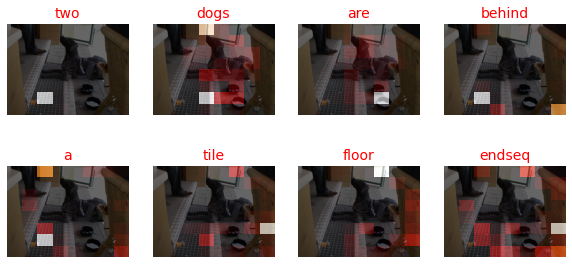

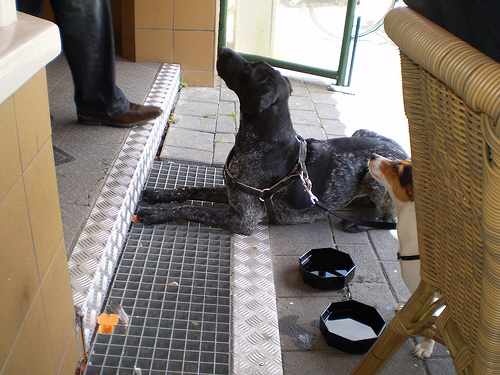

In [90]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)